In [23]:
import numpy as np
import cupy as cp
import h5py
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import sys
# Use managed memory
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)

# Init data sizes and parametes of the PXM of ID16A

In [24]:
n = 2048  # object size in each dimension
pad = n//8
npos= 16

detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 1.286e-3
z1 = np.tile(5.5e-3-sx0, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 2048//(2048//n)+2*pad
show = True

rho = 0.1#float(sys.argv[1])#0.5
flg = f'{n}_{rho}'
path = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_010nm_nfp_01/'
path_ref = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_010nm_nfp_02/'
path_out = f'/data/vnikitin/ESRF/ID16A/20240924_rec/SiemensLH/SiemensLH_010nm_nfp_01/'


print(f'{voxelsize=}')

voxelsize=1.0000052453125e-08


## Read data

[-86.00005  -80.000084 -79.000084 -82.00007  -77.0001   -77.0001
 -80.000084 -68.000046  68.000046  73.00012   74.000114  64.00006
  74.000114  69.00004   80.000084  77.0001  ] [-82.00007  -85.00005  -76.0001   -75.00011   73.00012   74.000114
  85.00005   83.00006   94.000114  76.0001    70.00003   71.00002
 -67.000046 -80.000084 -77.0001   -73.00012 ]


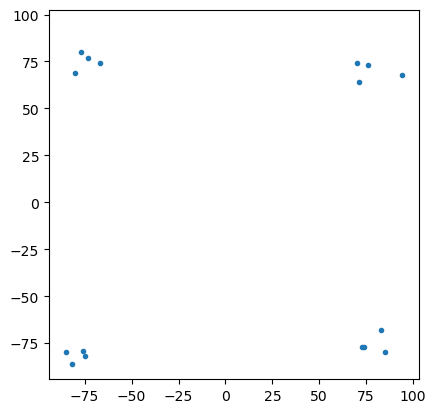

In [25]:
with h5py.File(f'{path}SiemensLH_010nm_nfp_010000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:npos].astype('float32')
    
with h5py.File(f'{path_ref}ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}SiemensLH_010nm_nfp_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

data0 = data0[np.newaxis]
print(spz,spy)
# spz = spz.astype('int32')
# spy = spy.astype('int32')

plt.plot(spy,spz,'.')
plt.axis('square')
plt.show()
shifts_code0 = np.zeros([1,npos,2],dtype='float32')
shifts_code0[:,:,1] = spy[:npos]
shifts_code0[:,:,0] = -spz[:npos]


for k in range(int(np.log2(2048//n))):
    data0 = (data0[:,:,::2]+data0[:,:,1::2])*0.5
    data0 = (data0[:,:,:,::2]+data0[:,:,:,1::2])*0.5
    ref0 = (ref0[:,::2]+ref0[:,1::2])*0.5
    ref0 = (ref0[:,:,::2]+ref0[:,:,1::2])*0.5    
    dark0 = (dark0[:,::2]+dark0[:,1::2])*0.5
    dark0 = (dark0[:,:,::2]+dark0[:,:,1::2])*0.5    



In [26]:
import scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    if (int(dezinger) > 0):
        w = int(dezinger)
        # print(data.shape)
        fdata = ndimage.median_filter(data, [1,w, w])
        print(np.sum(np.abs(data-fdata)>fdata*dezinger_threshold))
        res[:] = np.where(np.abs(data-fdata)>fdata*dezinger_threshold, fdata, data)
    return res

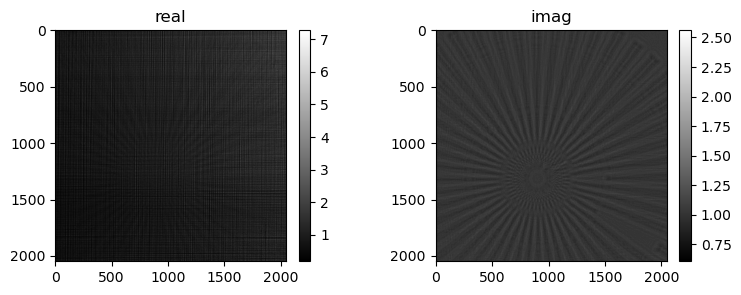

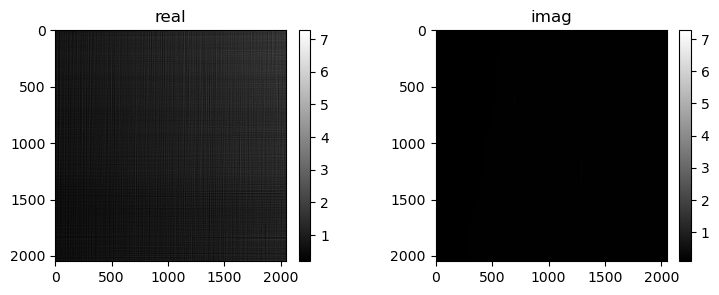

In [27]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
dark = np.mean(dark,axis=0)[np.newaxis]
ref = np.mean(ref,axis=0)[np.newaxis]
# data-=dark
# ref-=dark

# data[data<0]=0
# ref[ref<0]=0
# for k in range(data.shape[1]):
#     data[0,k,data[0,k]>ref[0]] = ref[0,data[0,k]>ref[0]]
data[:,:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
for k in range(npos):
    radius = 3
    threshold = 0.8
    dxchange.write_tiff(data[:,k],'/data2/tmp/t1',overwrite=True)
    # data[:,k] = remove_outliers(data[:,k], radius, threshold)
    dxchange.write_tiff(data[:,k],'/data2/tmp/t2',overwrite=True)    
    # ss
    
# ref[:] = remove_outliers(ref[:], radius, threshold)     
dxchange.write_tiff(ref[:],'/data2/tmp/t3',overwrite=True)    
data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

dxchange.write_tiff(data[:,0],'/data2/tmp/t4',overwrite=True)    
# data[np.isnan(data)] = 1
# ref[np.isnan(ref)] = 1

rdata = data/(ref+1e-6)

dxchange.write_tiff(rdata[:,0],'/data2/tmp/t5',overwrite=True)    
mshow_complex(data[0,0]+1j*rdata[0,0],show)
mshow_complex(ref[0]+1j*dark[0],show)


In [28]:
# data = np.pad(data,((0,0),(0,0),(pad,pad),(pad,pad)),'symmetric')
# ref = np.pad(ref,((0,0),(pad,pad),(pad,pad)),'symmetric')

# Construct operators


In [29]:
def Lop(psi):
    data = cp.zeros([*psi.shape[:2], n, n], dtype='complex64')
    for i in range(psi.shape[1]):
        psir = cp.array(psi[:,i])       
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([*data.shape[:2], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(data.shape[1]):
        datar = cp.array(data[:, j])
        psir = cp.pad(datar, ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j],'symmetric')        
        psi[:,j] = psir
    return psi

def Sop(psi,shifts):
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    psi = cp.array(psi)
    for i in range(npos):
        psir = psi.copy()
        shiftsr = cp.array(shifts[:, i])
        psir = S(psir, shiftsr)
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data,shifts):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        datar = cp.array(data[:,j])
        shiftsr = cp.array(shifts[:, j])        
        psir = cp.pad(datar,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shiftsr)
    return psi

# adjoint tests
tmp = cp.array(data).copy()
arr1 = cp.pad(tmp[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts = cp.array(shifts_code0)
arr2 = Sop(arr1,shifts*rho)
arr3 = STop(arr2,shifts*rho)

arr4 = Lop(arr2)
arr5 = LTop(arr4)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(arr2*np.conj(arr5))}==\n{np.sum(arr4*np.conj(arr4))}')

(79657456+0.409832239151001j)==
(79657448+9.251581900571182e-08j)
(79627688+0.6278781890869141j)==
(79627696-7.749707583570853e-05j)


## Reconstruction with the CG (Carlsson) with Hessians

### Define real-valued summation and dot product

In [30]:
def reprod(a,b):
    return a.real*b.real+a.imag*b.imag

def redot(a,b,axis=None):    
    res = np.sum(reprod(a,b),axis=axis)        
    return res

## Gradients

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde D\right)\right).$$
#### where $$\tilde D = D \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$



In [31]:
def gradientF(vars,d):
    (psi,q,x) = (vars['psi'], vars['prb'], vars['shift'])
    Lpsi = Lop(Sop(psi,x)*q)
    td = d*(Lpsi/np.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

def gradientFQ(vars,d):
    q = vars['prb']
    Lq = Lop(q[np.newaxis])[0]
    td = d*(Lq/np.abs(Lq))
    res = 2*LTop((Lq - td)[np.newaxis])[0]
    return res


##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right).$$
##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(\psi_0)}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$

#### new operator $$T_{\psi,w}(x) = C(\mathcal{F}^{-1}(w e^{-2\pi i \boldsymbol{x}_{0}\cdot \boldsymbol{\xi}}\hat{\psi_0}))$$




In [32]:
def gradientpsi(q,x,gradF):
    return STop(np.conj(q)*gradF,x)

def gradientq(psi,x,gradF):
    return np.sum(np.conj(Sop(psi,x))*gradF,axis=1)

def Twop_(psi,x,w):
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    psi = cp.array(psi)
    xi1 = cp.fft.fftfreq(2*ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for i in range(npos):
        psir = psi.copy()            
        p = cp.array(x[:,i])
        psir = cp.pad(psir, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)), 'symmetric')
        pp = w*cp.exp(-2*cp.pi*1j*(xi1*p[:, 0, None, None]+xi2*p[:, 1, None, None]))    
        psir = cp.fft.ifft2(pp*cp.fft.fft2(psir))   
        data[:,i] = psir[:, ne-n//2-pad:ne+n//2+pad, ne-n//2-pad:ne+n//2+pad]        
    return data

def gradientx(psi,q,x,gradF):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')    
    [xi2, xi1] = cp.meshgrid(xi1, xi1)  
    tksi1 = Twop_(psi,x,-2*cp.pi*1j*xi1)
    tksi2 = Twop_(psi,x,-2*cp.pi*1j*xi2)    
    gradx = cp.zeros([1,npos,2],dtype='float32')
    tmp = np.conj(q)*gradF
    gradx[:,:,0] = redot(tmp,tksi1,axis=(2,3))
    gradx[:,:,1] = redot(tmp,tksi2,axis=(2,3))
    return gradx

def gradients(vars,d,ref,gradF,gradQ):
    (psi,q,x) = (vars['psi'], vars['prb'], vars['shift'])
    grads = {}
    grads['psi'] = gradientpsi(q,x,gradF)
    grads['prb'] = gradientq(psi,x,gradF)+gradQ
    # grads['shift'] = rho*gradientx(psi,q,x,gradF)
    return grads

##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z)))\right\rangle.$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [33]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))    
    return 2*(v1+v2)

def hessianQ(hq,hq1,hq2,ref):
    Lq = Lop(hq[np.newaxis])[0]        
    Lq1 = Lop(hq1[np.newaxis])[0]        
    Lq2 = Lop(hq2[np.newaxis])[0]        
    
    l0 = Lq/np.abs(Lq)
    d0 = ref/np.abs(Lq)
    v1 = np.sum((1-d0)*reprod(Lq1,Lq2))
    v2 = np.sum(d0*reprod(l0,Lq1)*reprod(l0,Lq2))    
    return 2*(v1+v2)

#### $$ D T_\psi|_{{\boldsymbol{z}_0}}(\Delta \boldsymbol{z})=C(\mathcal{F}^{-1}(-2\pi i\xi_1 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))\Delta {z}_{1}+C(\mathcal{F}^{-1}(-2\pi i\xi_2 e^{-2\pi i \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))\Delta {z}_2$$

In [34]:

def DT(psi,x,dx):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    tksi1 = Twop_(psi,x,-2*cp.pi*1j*xi1)
    tksi2 = Twop_(psi,x,-2*cp.pi*1j*xi2)
    res = tksi1*dx[:,:,0,None,None]+tksi2*dx[:,:,1,None,None]
    return res

#### $$D^2{T_\psi}|_{{\boldsymbol{z}_0}}(\Delta\boldsymbol{z},\Delta\boldsymbol{w})=$$
#### $$\Delta {z}_{1}\Delta {w}_{1} C(\mathcal{F}^{-1}(-4\pi^2 \xi_1^2 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi})) +(\Delta {z}_{1}\Delta {w}_{2} +$$
#### $$ \Delta {w}_{1}\Delta {z}_{2})C(\mathcal{F}^{-1}(-4\pi^2 \xi_1\xi_2 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))+\Delta {z}_{2}\Delta {w}_{2} C(\mathcal{F}^{-1}(-4\pi^2\xi_2^2 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))$$

In [35]:
def D2T(psi,x,dx1,dx2):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    [xi2,xi1] = cp.meshgrid(xi1, xi1)
    dx11 = dx1[:,:,:,None,None] 
    dx22 = dx2[:,:,:,None,None] 
    res = dx11[:,:,0]*dx22[:,:,0]*Twop_(psi,x,-4*cp.pi**2*xi1**2)+ \
         (dx11[:,:,0]*dx22[:,:,1]+dx11[:,:,1]*dx22[:,:,0])*Twop_(psi,x,-4*cp.pi**2*xi1*xi2)+ \
          dx11[:,:,1]*dx22[:,:,1]*Twop_(psi,x,-4*cp.pi**2*xi2**2)
    return res

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [36]:
def DM(psi,q,x,dpsi,dq,dx):
    res = dq*Sop(psi,x)+q*(Sop(dpsi,x)+rho*DT(psi,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [37]:
def D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*rho*DT(dpsi1,x,dx2) + q*rho*DT(dpsi2,x,dx1) + q*rho**2*D2T(psi,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,x) + dq2*Sop(dpsi1,x) 
    res += dq1*rho*DT(psi,x,dx2) + dq2*rho*DT(psi,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big).$$

In [38]:
def hessian2(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2,d,ref,gradF):
    d2m = D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    dm1 = DM(psi,q,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q    
        
    return redot(gradF,d2m)+hessianF(sq, dm1,dm2,d)+hessianQ(q,dq1,dq2,ref)      

In [39]:
def calc_beta(vars,grads,etas,d,ref,gradF,gradQ):
    (psi,q,x) = (vars['psi'], vars['prb'], vars['shift'])
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['shift'])
    
    dm1 = DM(psi,q,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    d2m1 = D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    d2m2 = D2M(psi,q,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q

    top = redot(gradF,d2m1)    
    top += hessianF(sq, dm1, dm2, d)+hessianQ(q,dq1,dq2,ref)  

    bottom = redot(gradF,d2m2)    
    bottom += hessianF(sq, dm2, dm2, d)+hessianQ(q,dq2,dq2,ref)  

    return top/bottom

def calc_alpha(vars,grads,etas,d,ref,gradF,gradQ):    
    (psi,q,x) = (vars['psi'], vars['prb'], vars['shift'])
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['shift'])
    
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    d2m2 = D2M(psi,q,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q
    
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    bottom = redot(gradF,d2m2)+hessianF(sq, dm2, dm2, d)+hessianQ(q,dq2,dq2,ref)  
    
    return top/bottom, top, bottom

### Initial guess for reconstruction (Paganin)

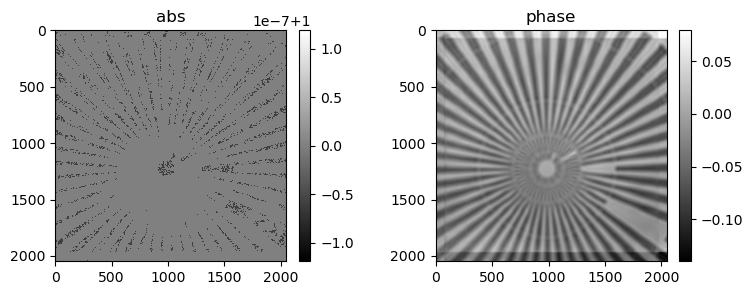

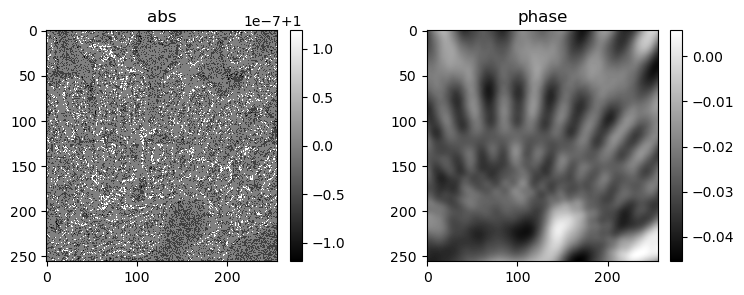

In [40]:
def rec_init(rdata,shifts):
    recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 1.2e-2)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'symmetric')   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'symmetric')   
        shiftsr = cp.array(shifts[:,j])
        recMultiPaganin[:,j] = ST(r,shiftsr).real
        recMultiPaganinr[:,j] = ST(rr,shiftsr).real
        
    recMultiPaganin = np.sum(recMultiPaganin,axis=1)
    recMultiPaganinr = np.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    v = cp.ones(ne,dtype='float32')
    v[:pad] = np.sin(cp.linspace(0,1,pad)*np.pi/2)
    v[ne-pad:] = np.cos(cp.linspace(0,1,pad)*np.pi/2)
    v = np.outer(v,v)
    recMultiPaganin*=v
    recMultiPaganin = np.exp(1j*recMultiPaganin)

    return recMultiPaganin

rec_paganin = rec_init(rdata,shifts)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)

## debug functions

In [41]:
def minf(fpsi,fprb,data,ref):
    f = np.linalg.norm(np.abs(fpsi)-data)**2+np.linalg.norm(np.abs(fprb)-ref)**2
    return f

def plot_debug2(vars,etas,top,bottom,alpha,data,ref):
    (psi,q,x) = (vars['psi'], vars['prb'], vars['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'],etas['prb'],etas['shift'])
    npp = 17
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*dpsi2
        qt = q+(alpha*k/(npp-1))*dq2
        xt = x+(alpha*k/(npp-1))*dx2*rho
        fpsit = Lop(Sop(psit,xt)*qt)
        fqt = Lop(qt[np.newaxis])[0]
        
        errt[k] = minf(fpsit,fqt,data,ref)    

    t = alpha*(cp.arange(2*npp))/(npp-1)
    errt2 = minf(Lop(Sop(psi,x)*q),Lop(q[np.newaxis])[0],data,ref)-top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    plt.plot(shifts_init[0,:,0].get()-(shifts[0,:,0].get()),'r.')
    plt.plot(shifts_init[0,:,1].get()-(shifts[0,:,1].get()),'b.')
    plt.show()

def vis_debug(vars,i):
    mshow_polar(vars['psi'][0],show)
    mshow_polar(vars['psi'][0,ne//2-256:ne//2+256,ne//2+512:ne//2+1024],show)
    mshow_polar(vars['prb'][0],show)
    dxchange.write_tiff(np.angle(vars['psi'][0]).get(),f'{path_out}/crec_code_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(vars['prb'][0]).get(),f'{path_out}/crec_prb_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(vars['psi'][0]).get(),f'{path_out}/crec_code_abs{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(vars['prb'][0]).get(),f'{path_out}/crec_prb_abs{flg}/{i:03}',overwrite=True)
    np.save(f'{path_out}/crec_shift{flg}_{i:03}',vars['shift'])

    
def err_debug(vars, grads, data, ref):    
    err = minf(Lop(Sop(vars['psi'],vars['shift'])*vars['prb']),Lop(vars['prb'][np.newaxis])[0],data,ref)    
    print(f'gradient norms (psi, prb, shift): {np.linalg.norm(grads['psi']):.2f}, {np.linalg.norm(grads['prb']):.2f}, {np.linalg.norm(grads['shift']):.2f}')                        
    return err

# Main CG loop (fifth rule)

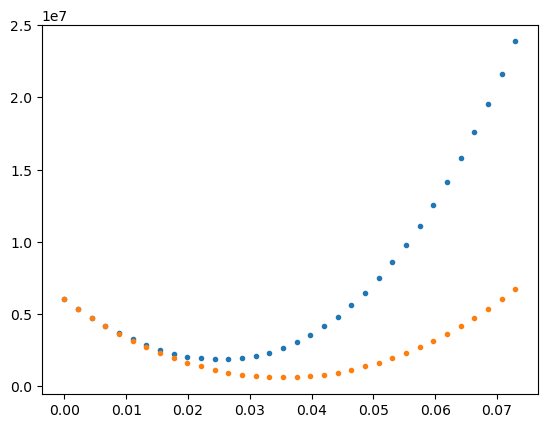

gradient norms (psi, prb, shift): 10821.33, 13721.51, 0.00
0) alpha=0.03538, err=2.66205e+06


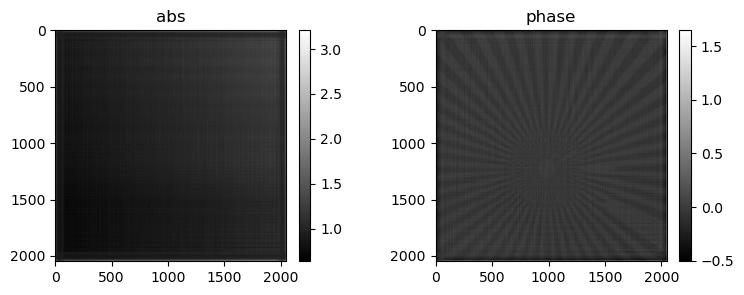

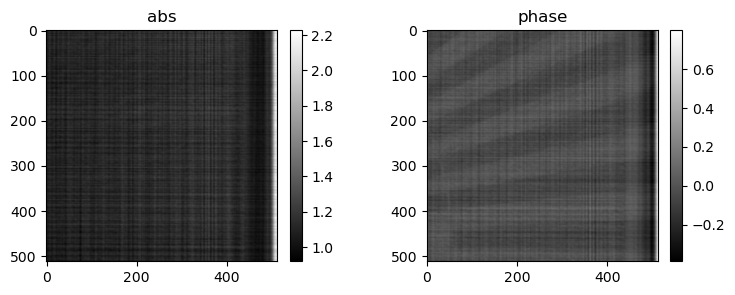

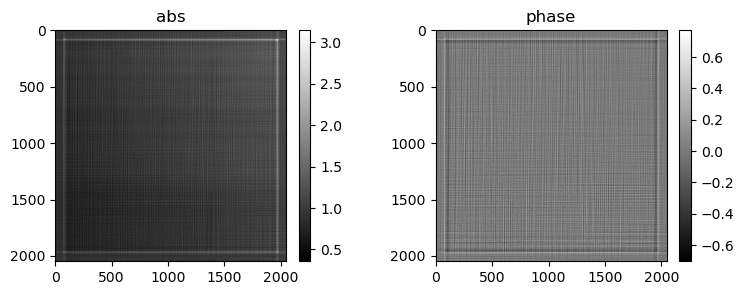

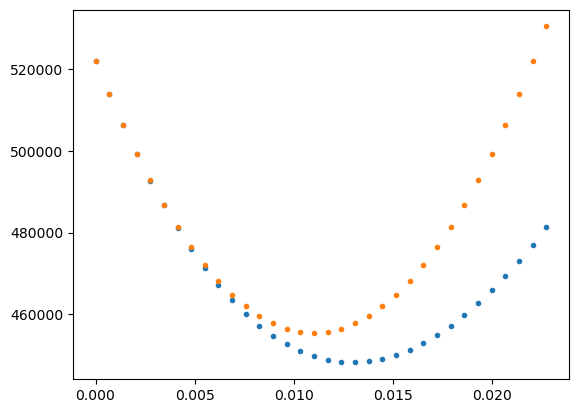

gradient norms (psi, prb, shift): 2360.08, 3160.83, 0.00
4) alpha=0.01103, err=4.49667e+05


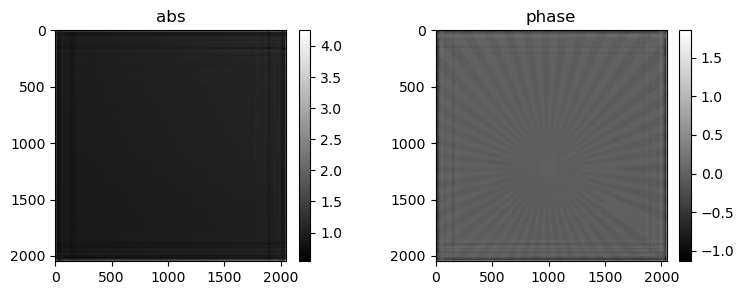

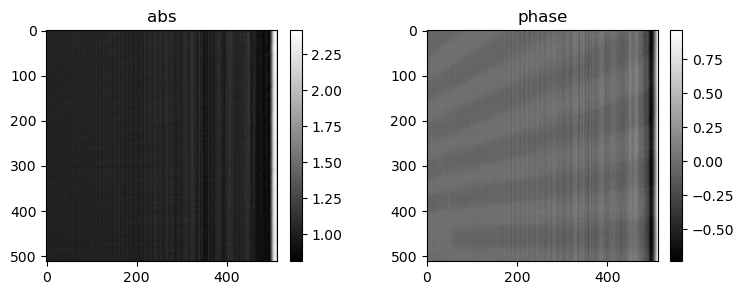

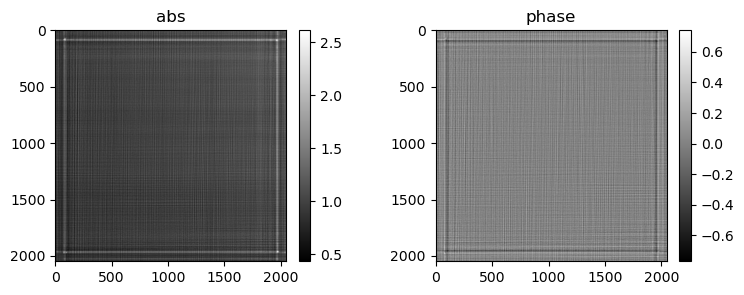

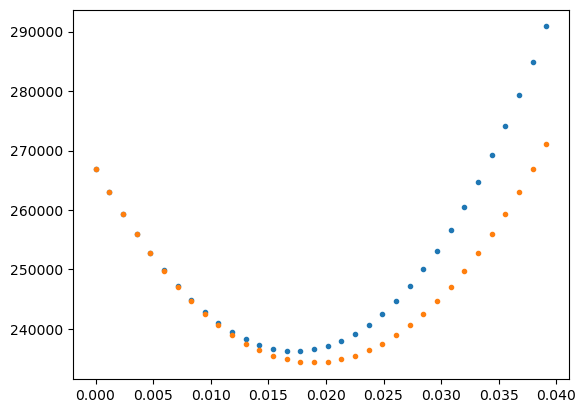

gradient norms (psi, prb, shift): 1023.88, 1495.55, 0.00
8) alpha=0.01898, err=2.36556e+05


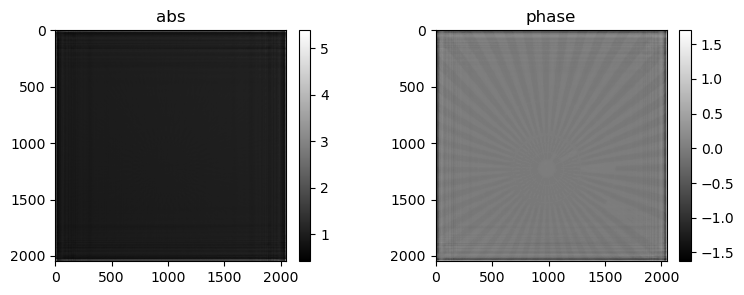

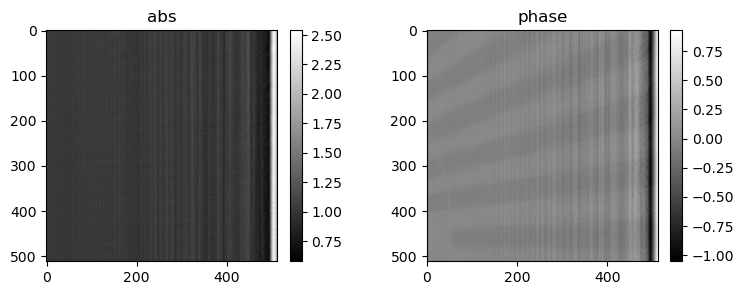

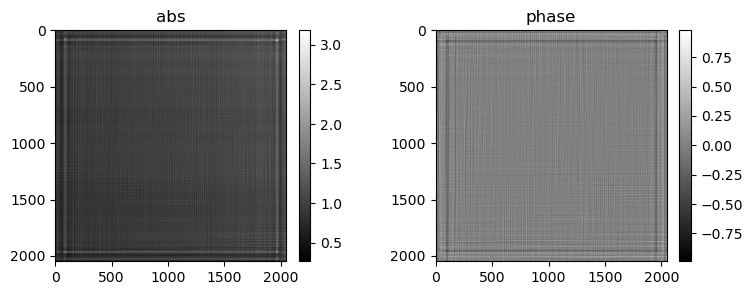

KeyboardInterrupt: 

In [42]:
def cg_holo(data, ref, vars, pars):

    data = np.sqrt(data)    
    ref = np.sqrt(ref)    
    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    
    shifts_init = vars['shift'].copy()
    for i in range(pars['niter']):           
        #vars['prb'] = cp.pad(vars['prb'][:,pad:-pad,pad:-pad], ((0,0),(pad,pad),(pad,pad)),'symmetric')
        gradF = gradientF(vars,data)
        gradQ = gradientFQ(vars,ref)
        
        grads = gradients(vars,data,ref,gradF,gradQ)
        grads['shift'] = shifts*0
        # if i<16:
            # grads['psi'][:]=0
        
        # etas = {}
        # etas['psi'] = -grads['psi']
        # etas['prb'] = -grads['prb']
        # etas['shift'] = -grads['shift']
        
        if i==0:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['prb'] = -grads['prb']
            etas['shift'] = -grads['shift']
        else:      
            beta = calc_beta(vars, grads, etas, data, ref, gradF, gradQ)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['shift'] = -grads['shift'] + beta*etas['shift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, data, ref, gradF, gradQ) 
        if i % pars['vis_step'] == 0:
            plot_debug2(vars,etas,top,bottom,alpha,data,ref)

        vars['psi'] += alpha*etas['psi']
        vars['prb'] += alpha*etas['prb']
        vars['shift'] += alpha*rho*etas['shift']
        
        if i % pars['err_step'] == 0:
            err = err_debug(vars, grads, data, ref)    
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha

        if i % pars['vis_step'] == 0:
            vis_debug(vars, i)
            # plot_debug3(vars['shift'],shifts_init)            
            
    return vars,erra,alphaa

vars = {}
vars['psi'] = cp.array(rec_paganin).copy()
vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
vars['shift'] = cp.array(shifts)
data = cp.array(data)
ref = cp.array(ref)

# iter=48
# prb_angle = dxchange.read_tiff(f'/data2/vnikitin/nfp_codes_correct/crec_prb_angle{n}_-0.01775full0.3//{iter:03}.tiff')
# prb_abs = dxchange.read_tiff(f'/data2/vnikitin/nfp_codes_correct/crec_prb_abs{n}_-0.01775full0.3//{iter:03}.tiff')
# prb = prb_abs*np.exp(1j*prb_angle)[np.newaxis]
# mshow_polar(prb[0],show)
# prb = prb[:,prb.shape[1]//2-n//2-pad:prb.shape[1]//2+n//2+pad,prb.shape[2]//2-n//2-pad:prb.shape[2]//2+n//2+pad]

# vars['prb']=cp.array(prb)
pars = {'niter': 2049, 'err_step': 4, 'vis_step': 4}
vars,erra,alphaa = cg_holo(data,ref, vars, pars)   